In [ ]:
import torch
from torch.nn import functional as F
from torchvision import transforms
from torch import nn, Tensor
from dataset import *
from utils import *
import numpy as np
import torchvision
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class RPNHead(torch.nn.Module):

    def __init__(self,  device='cuda', anchors_param=dict(ratio=0.8,scale= 256, grid_size=(50, 68), stride=16)):
        # Initialize the backbone, intermediate layer clasifier and regressor heads of the RPN
        super(RPNHead,self).__init__()

        self.device=device
        # TODO Define Backbone
        self.__init_layers()
        # TODO  Define Intermediate Layer
        #  find anchors
        self.anchors_param=anchors_param
        self.anchors= self.create_anchors(self.anchors_param['ratio'],self.anchors_param['scale'],self.anchors_param['grid_size'],self.anchors_param['stride'])
        self.anchors = self.anchors.to(device)
        self.ground_dict={}
        self.image_w = 1088
        self.image_h = 800


    
    def __init_layers(self):
        
        self.backbone= nn.ModuleList()
        self.backbone.append(nn.Sequential(torch.nn.Conv2d(3,16,kernel_size=5,padding=2, stride=1), torch.nn.BatchNorm2d(16), torch.nn.ReLU(inplace = False)))
        self.backbone.append(torch.nn.MaxPool2d(2,stride=2, padding=0))
        self.backbone.append(nn.Sequential(torch.nn.Conv2d(16,32,kernel_size=5,padding=2, stride=1), torch.nn.BatchNorm2d(32), torch.nn.ReLU(inplace = False)))
        self.backbone.append(torch.nn.MaxPool2d(2,stride=2, padding=0))
        self.backbone.append(nn.Sequential(torch.nn.Conv2d(32,64,kernel_size=5,padding=2, stride=1), torch.nn.BatchNorm2d(64), torch.nn.ReLU(inplace = False)))
        self.backbone.append(torch.nn.MaxPool2d(2,stride=2, padding=0))
        self.backbone.append(nn.Sequential(torch.nn.Conv2d(64,128, kernel_size=5,padding=2, stride=1), torch.nn.BatchNorm2d(128), torch.nn.ReLU(inplace = False)))
        self.backbone.append(torch.nn.MaxPool2d(2,stride=2, padding=0))        
        self.backbone.append(nn.Sequential(torch.nn.Conv2d(128, 256, kernel_size=5,padding=2, stride=1), torch.nn.BatchNorm2d(256), torch.nn.ReLU(inplace = False)))
        
        self.intermediate_layer = nn.Sequential(torch.nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1), torch.nn.BatchNorm2d(256), torch.nn.ReLU(inplace = False))
        
        self.classifier_head = nn.Sequential(torch.nn.Conv2d(256, 1, kernel_size=1, padding=0, stride=1), torch.nn.Sigmoid())
        self.regressor_head  = nn.Sequential(torch.nn.Conv2d(256, 4, kernel_size=1, padding=0, stride=1), torch.nn.Sigmoid())
        
    # Forward  the input through the backbone the intermediate layer and the RPN heads
    # Input:
    #       X: (bz,3,image_size[0],image_size[1])}
    # Ouput:
    #       logits: (bz,1,grid_size[0],grid_size[1])}
    #       bbox_regs: (bz,4, grid_size[0],grid_size[1])}
    def forward(self, X):

        #TODO forward through the Backbone
        out = self.forward_backbone(X)
        #TODO forward through the Intermediate layer
        out = self.intermediate_layer(out)
        #TODO forward through the Classifier Head
        logits = self.classifier_head(out)
        #TODO forward through the Regressor Head
        bbox_regs = self.regressor_head(out)

        assert logits.shape[1:4]==(1,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])
        assert bbox_regs.shape[1:4]==(4,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])

        return logits, bbox_regs




    # Forward input batch through the backbone
    # Input:
    #       X: (bz,3,image_size[0],image_size[1])}
    # Ouput:
    #       X: (bz,256,grid_size[0],grid_size[1])
    def forward_backbone(self,X):
        #####################################
        # TODO forward through the backbone
        #####################################
        for l in self.backbone:
            X = l(X)

        assert X.shape[1:4]==(256,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])
        return X


    #input:
    #anchors: (grid_size[0],grid_size[1],4)                         :(x_center, y_center, w, h)
    #gt:      (n_bboxes, grid_size[0], grid_size[1], 4)             :(x1,y1,x2,y2)
    #Output:
    #iou : (n_boxes, grid[0], grid[1])
    def iou(self, anchors, gt):
      #Extracting centers and h w
      cpx = anchors[:,:,0]                                           #[grid[0],grid[1]]                                        
      cpy = anchors[:, : ,1]                                         #[grid[0],grid[1]]
      wp  = anchors[:, : ,2]                                         #[grid[0],grid[1]]
      hp  = anchors[:, : ,3]                                         #[grid[0],grid[1]]
      
      
      cgx = gt[:,:,:,0]                                              #[n_boxes,grid[0],grid[1]]
      cgy = gt[:,:,:,1]                                              #[n_boxes,grid[0],grid[1]]
      wg  = gt[:,:,:,2]                                              #[n_boxes,grid[0],grid[1]] 
      hg  = gt[:,:,:,3]                                              #[n_boxes,grid[0],grid[1]]
      
      #Box format [x1 y1 x2 y2]
      box1 =  [cpx-wp/2, cpy-hp/2, cpx+wp/2, cpy+hp/2]
      box2 =  [cgx-wg/2, cgy-hg/2, cgx+wg/2, cgy+hg/2]
      # box2 =  [cgx, cgy, cgx, cgy]

      xA = torch.max(box1[0], box2[0])                                #[n_boxes,grid[0],grid[1]] 
      yA = torch.max(box1[1], box2[1])                                #[n_boxes,grid[0],grid[1]]
    
      xB = torch.min(box1[2], box2[2])                                #[n_boxes,grid[0],grid[1]]
      yB = torch.min(box1[3], box2[3])                                #[n_boxes,grid[0],grid[1]]
    
      area_intersection = torch.max(xB-xA, torch.zeros(xB.shape, dtype=xB.dtype)) * torch.max(yB-yA, torch.zeros(yB.shape, dtype=yB.dtype))
    
      area_union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - area_intersection
    
      iou = torch.div(area_intersection+1,area_union+1)
      return iou



    # This function creates the anchor boxes
    # Output:
    #       anchors: (grid_size[0],grid_size[1],4)
    def create_anchors(self, aspect_ratio, scale, grid_sizes, stride):
        ######################################
        # TODO create anchors
        ######################################
        
        anchors = torch.zeros((grid_sizes[0],grid_sizes[1],4))
        yy,xx = torch.meshgrid([torch.linspace(0, grid_sizes[0]-1, grid_sizes[0]), torch.linspace(0, grid_sizes[1]-1, grid_sizes[1])])
        yy,xx = yy*stride, xx*stride
        yy,xx = yy+(stride/2), xx+(stride/2)
        
        anchors[:,:,0] = xx
        anchors[:,:,1] = yy
        
        h = np.sqrt(scale*scale/aspect_ratio)
        w = aspect_ratio*h    
        
        anchors[:,:,2] = w
        anchors[:,:,3] = h
        
        assert anchors.shape == (grid_sizes[0] , grid_sizes[1],4)

        return anchors



    def get_anchors(self):
        return self.anchors



    # This function creates the ground truth for a batch of images by using
    # create_ground_truth internally
    # Input:
    #      bboxes_list: list:len(bz){(n_obj,4)}
    #      indexes:      list:len(bz)
    #      image_shape:  tuple:len(2)
    # Output:
    #      ground_clas: (bz,1,grid_size[0],grid_size[1])
    #      ground_coord: (bz,4,grid_size[0],grid_size[1])
    def create_batch_truth(self,bboxes_list,indexes,image_shape):
        #####################################
        # TODO create ground truth for a batch of images
        #####################################
        assert ground_clas.shape[1:4]==(1,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])
        assert ground_coord.shape[1:4]==(4,self.anchors_param['grid_size'][0],self.anchors_param['grid_size'][1])

        return ground_clas, ground_coord


    # This function creates the ground truth for one image
    # It also caches the ground truth for the image using its index
    # Input:
    #       bboxes:      (n_boxes,4)
    #       index:       scalar (the index of the image in the total dataset used for caching)
    #       grid_size:   tuple:len(2)
    #       anchors:     (grid_size[0],grid_size[1],4)
    # Output:
    #       ground_clas:  (1,grid_size[0],grid_size[1])
    #       ground_coord: (4,grid_size[0],grid_size[1])
    def create_ground_truth(self, bboxes, index, grid_size, anchors, image_size):
        key = str(index)
        if key in self.ground_dict:
            groundt, ground_coord = self.ground_dict[key]
            return groundt, ground_coord

        #####################################################
        # TODO create ground truth for a single image
        #####################################################
        self.image_w = image_size[1]
        self.image_h = image_size[0]

        bboxes = bboxes.cpu()
        anchors = anchors.cpu()
        # change bounding boxes to (x_center, y_center, w,h)
        bbox = torch.clone(bboxes)
        bboxes[:,0] = (bbox[:,0] + bbox[:,2])/2
        bboxes[:,1] = (bbox[:,1] + bbox[:,3])/2
        bboxes[:,2] = bbox[:,2] - bbox[:,0]
        bboxes[:,3] = bbox[:,3] - bbox[:,1]

        gt = torch.zeros(bboxes.shape[0], grid_size[0], grid_size[1], 4)
        for i in range(bboxes.shape[0]):
            gt[i,:,:,0]=bboxes[i,0]
            gt[i,:,:,1]=bboxes[i,1]
            gt[i,:,:,2]=bboxes[i,2]
            gt[i,:,:,3]=bboxes[i,3]

        ground_coord = torch.ones((4, grid_size[0], grid_size[1]))
        ground_clas = torch.ones((1, grid_size[0], grid_size[1]))*(-1)

        #To do: remove cross boundary anchors

        iou = self.iou(anchors, gt)   #(n_boxes, grid[0], grid[1])

        iou_p_bin = torch.zeros_like(iou, dtype = torch.bool)
        iou_n_bin = torch.zeros_like(iou, dtype = torch.bool)
      
        #### Thresholding ####
        
        for i in range(iou.shape[0]):
            max_iou = torch.max(iou[i])
            iou_p_bin[i] = torch.logical_or( (iou[i] >= 0.99*max_iou), (iou[i] > 0.7 ))  # positive label for every bounding box is where iou is max or it's greater than 0.7

            iou_n_bin[i] = torch.logical_and(~iou_p_bin[i], (iou[i] < 0.3)) # negative label for every bounding box is where it's not positive and iou < 0.7

        pos_labels = (torch.sum(iou_p_bin, dim = 0) > 0)
        neg_labels = (torch.sum(iou_n_bin, dim = 0) == iou.shape[0])

        out_anchor = ((anchors[:,:,0] - (anchors[:,:,2]/2)) < 0 ) + \
                     ((anchors[:,:,1] - (anchors[:,:,3]/2)) < 0 ) + \
                     ((anchors[:,:,0] + (anchors[:,:,2]/2)) > self.image_w ) + \
                     ((anchors[:,:,1] + (anchors[:,:,3]/2)) > self.image_h )

        ground_clas[0,pos_labels] = 1
        ground_clas[0,neg_labels] = 0
        ground_clas[0,out_anchor] = -1
        

        iou_max, iou_max_idx = torch.max(iou, dim = 0)
        
        ground_coord[:,pos_labels] = bboxes[iou_max_idx[pos_labels],:].T

        ground_coord[0,:,:] = (ground_coord[0,:,:] - anchors[:,:,0])/anchors[:,:,2]
        ground_coord[1,:,:] = (ground_coord[1,:,:] - anchors[:,:,1])/anchors[:,:,3]

        #Deal with case when log is 0 here
        ground_coord[2,:,:] = torch.log(ground_coord[2,:,:]/anchors[:,:,2])
        ground_coord[3,:,:] = torch.log(ground_coord[3,:,:]/anchors[:,:,3])

        ground_clas  = ground_clas.to(self.device)
        ground_coord = ground_coord.to(self.device)
        self.ground_dict[key] = (ground_clas, ground_coord)

        assert ground_clas.shape==(1,grid_size[0],grid_size[1])
        assert ground_coord.shape==(4,grid_size[0],grid_size[1])

        return ground_clas, ground_coord





    # Compute the loss of the classifier
    # Input:
    #      p_out:     (positives_on_mini_batch)  (output of the classifier for sampled anchors with positive gt labels)
    #      n_out:     (negatives_on_mini_batch) (output of the classifier for sampled anchors with negative gt labels
    def loss_class(self,p_out,n_out):

        #torch.nn.BCELoss()
        # TODO compute classifier's loss
        ones  = torch.ones(p_out.shape[0]).to(self.device)
        zeros = torch.zeros(n_out.shape[0]).to(self.device)
        target = torch.cat((ones,zeros),0)
        out    = torch.cat((p_out,n_out),0)
        BCE_loss = torch.nn.BCELoss(reduction = 'sum')
        loss = BCE_loss(out,target)
        sum_count = 1

        return loss,sum_count



    # Compute the loss of the regressor
    # Input:
    #       pos_target_coord: (positive_on_mini_batch,4) (ground truth of the regressor for sampled anchors with positive gt labels)
    #       pos_out_r: (positive_on_mini_batch,4)        (output of the regressor for sampled anchors with positive gt labels)
    def loss_reg(self,pos_target_coord,pos_out_r):
            #torch.nn.SmoothL1Loss()
            # TODO compute regressor's loss

            L1_loss = torch.nn.SmoothL1Loss(reduction = 'sum')
            loss = L1_loss(pos_out_r,pos_target_coord)
            sum_count = 1
            return loss, sum_count



    # Compute the total loss
    # Input:
    #       clas_out: (bz,1,grid_size[0],grid_size[1])
    #       regr_out: (bz,4,grid_size[0],grid_size[1])
    #       targ_clas:(bz,1,grid_size[0],grid_size[1])
    #       targ_regr:(bz,4,grid_size[0],grid_size[1])
    #       l: lambda constant to weight between the two losses
    #       effective_batch: the number of anchors in the effective batch (M in the handout)
    def compute_loss(self,clas_out,regr_out,targ_clas,targ_regr, l=1, effective_batch=50):
            #############################
            # TODO compute the total loss
            #############################
            M = effective_batch
            clas_out  = clas_out.flatten()                     #Shape: (bz*1*50*68)
            targ_clas = targ_clas.flatten()                    #Shape: (bz*1*50*68)
            n_pos = (targ_clas == 1).sum()
            n_neg = (targ_clas == 0).sum()
            if n_pos < (M/2):
              num_neg_sample       = M - n_pos.item()
              neg_idx              = np.random.choice(n_neg.item(), num_neg_sample, replace = False)
              pos_idx              = torch.arange(n_pos.item())
              p_out                = clas_out[targ_clas == 1]
              n_out                = clas_out[targ_clas == 0][neg_idx]
            else:
              pos_idx              = np.random.choice(n_pos.item(), M//2, replace = False)
              neg_idx              = np.random.choice(n_neg.item(), M//2, replace = False)
              p_out                = clas_out[targ_clas == 1][pos_idx]
              n_out                = clas_out[targ_clas == 0][neg_idx]

            loss_c, count_c = self.loss_class(p_out,n_out)
            
            regr_out  = regr_out.transpose(0,1)                    #Shape: (4,bz,50,68)
            targ_regr = targ_regr.transpose(0,1)                   #Shape: (4,bz,50,68)
            regr_out  = regr_out.flatten(start_dim = 1)            #Shape: (4,bz*3400) 
            targ_regr = targ_regr.flatten(start_dim = 1)            #Shape: (4,bz*3400)

            regr_out  = regr_out.T
            targ_regr = targ_regr.T

            pos_out_r        = regr_out[targ_clas == 1, :][pos_idx,:]
            pos_target_coord = targ_regr[targ_clas == 1,:][pos_idx,:]

            loss_r, count_r = self.loss_reg(pos_target_coord, pos_out_r) 

            l=5
            loss = loss_c + l*loss_r

            return loss, loss_c, loss_r



    # Post process for the outputs for a batch of images
    # Input:
    #       out_c:  (bz,1,grid_size[0],grid_size[1])}
    #       out_r:  (bz,4,grid_size[0],grid_size[1])}
    #       IOU_thresh: scalar that is the IOU threshold for the NMS
    #       keep_num_preNMS: number of masks we will keep from each image before the NMS
    #       keep_num_postNMS: number of masks we will keep from each image after the NMS
    # Output:
    #       nms_clas_list: list:len(bz){(Post_NMS_boxes)} (the score of the boxes that the NMS kept)
    #       nms_prebox_list: list:len(bz){(Post_NMS_boxes,4)} (the coordinates of the boxes that the NMS kept)
    def postprocess(self,out_c,out_r, IOU_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=10):
            ####################################
            # TODO postprocess a batch of images
            #####################################
            out_c_list = []
            out_r_list = []
            bz = out_c.shape[0]
            for i in range(bz):
              out_c_list.append(out_c[i])
              out_r_list.append(out_r[i])

            nms_clas_list, nms_prebox_list = MultiApply(self.postprocessImg, out_c_list, out_r_list, [IOU_thresh]*bz, [keep_num_preNMS]*bz, [keep_num_postNMS]*bz)
            return nms_clas_list, nms_prebox_list



    # Post process the output for one image
    # Input:
    #      mat_clas: (1,grid_size[0],grid_size[1])}  (scores of the output boxes)
    #      mat_coord: (4,grid_size[0],grid_size[1])} (encoded coordinates of the output boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4) (decoded coordinates of the boxes that the NMS kept)
    def postprocessImg(self,mat_clas,mat_coord, IOU_thresh,keep_num_preNMS, keep_num_postNMS):
            ######################################
            # TODO postprocess a single image
            #####################################
            
            #Decode box coordinates to (x,y,w,h)
            mat_coord[0,:,:] = mat_coord[0,:,:]*self.anchors[:,:,2] + self.anchors[:,:,0]
            mat_coord[1,:,:] = mat_coord[1,:,:]*self.anchors[:,:,3] + self.anchors[:,:,1]
            mat_coord[2,:,:] = torch.exp(mat_coord[2,:,:])*self.anchors[:,:,2]
            mat_coord[3,:,:] = torch.exp(mat_coord[3,:,:])*self.anchors[:,:,3]

            out_anchor = ((mat_coord[0,:,:] - (mat_coord[2,:,:]/2)) < 0 ) + \
                         ((mat_coord[1,:,:] - (mat_coord[3,:,:]/2)) < 0 ) + \
                         ((mat_coord[0,:,:] + (mat_coord[2,:,:]/2)) > self.image_w ) + \
                         ((mat_coord[1,:,:] + (mat_coord[3,:,:]/2)) > self.image_h )

            mat_clas[0,out_anchor] = 0

            scores = mat_clas.flatten()                                             #Shape: (grid[0]*grid[1])

            sort_scores, sort_idx = torch.sort(scores,descending = True)           
            
            boxes = mat_coord.flatten(start_dim = 1)                                #Shape: (4,grid[0]*grid[1])
            prebox = boxes[:,sort_idx[0:keep_num_preNMS]]                           #Shape: (4,top k boxes)
            prebox = prebox.T                                                       #Shape: (top k boxes,4)

            pre_score = scores[sort_idx[0:keep_num_preNMS]]                         #Shape: (top k boxes)
            
            post_score, post_box  = self.NMS(pre_score, prebox, IOU_thresh)         #post_score = (top k boxes), post_box = (top k boxes,4)

            nms_clas = post_score[0:keep_num_postNMS]
            nms_prebox = post_box[0:keep_num_postNMS,:]

            pos_class = (nms_clas>0).sum().item()
            nms_clas = nms_clas[0:pos_class]
            nms_prebox = nms_prebox[0:pos_class,:]

            return nms_clas, nms_prebox



    # Input:
    #       clas: (top_k_boxes) (scores of the top k boxes)
    #       prebox: (top_k_boxes,4) (coordinate of the top k boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4)
    def NMS(self,clas,prebox, thresh):
        ##################################
        # TODO perform NSM
        ##################################

        gauss_sigma = 0.5

        xA = prebox[:,0] - (prebox[:,2]/2).reshape(-1,1)
        yA = prebox[:,1] - (prebox[:,3]/2).reshape(-1,1)
        xB = prebox[:,0] + (prebox[:,2]/2).reshape(-1,1)
        yB = prebox[:,1] + (prebox[:,3]/2).reshape(-1,1)

        inter_xA = torch.max(xA,xA.T)
        inter_yA = torch.max(yA,yA.T)
        inter_xB = torch.min(xB,xB.T)
        inter_yB = torch.min(yB,yB.T)

        inter_area = torch.max(inter_xB - inter_xA + 1, torch.zeros(inter_xB.shape[0],dtype = inter_xB.dtype, device = self.device)) * \
                     torch.max(inter_yB - inter_yA + 1, torch.zeros(inter_yB.shape[0],dtype = inter_yB.dtype, device = self.device))

        union_area = (xB - xA + 1) * (yB - yA + 1) + (xB.T - xA.T + 1) * (yB.T - yA.T + 1) - inter_area

        ious = torch.div(inter_area , union_area).triu(diagonal = 1)
        ious[ious < thresh] = 0

        ious_cmax, ious_cmax_idx = ious.max(0)
        ious_cmax = ious_cmax.expand(clas.shape[0],clas.shape[0]).T

        decay = torch.exp(-(ious.pow(2)-ious_cmax.pow(2))/gauss_sigma)

        decay, decay_idx = decay.min(dim = 0)

        decay_clas = clas*decay

        decay_sort_score, decay_sort_idx = torch.sort(decay_clas,descending = True)
        
        nms_prebox = prebox[decay_sort_idx,:]
        nms_clas = decay_sort_score

        return nms_clas,nms_prebox

In [ ]:
model_path = '/content/drive/My Drive/CIS680_2019/HW4/'
imgs_path = '/content/drive/My Drive/CIS680_2019/HW3/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '/content/drive/My Drive/CIS680_2019/HW3/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "/content/drive/My Drive/CIS680_2019/HW3/data/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "/content/drive/My Drive/CIS680_2019/HW3/data/hw3_mycocodata_bboxes_comp_zlib.npy"    
paths = [imgs_path, masks_path, labels_path, bboxes_path]

dataset = BuildDataset(paths)

  
# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# push the randomized training data into the dataloader

# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)
batch_size = 4
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

In [ ]:
resume = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

anchors_param = dict(ratio=0.8,scale= 256, grid_size=(50, 68), stride=16)

rpn_net = RPNHead(device = device, anchors_param = anchors_param)
rpn_net.to(device)

num_epochs= 40
epoch = -1

lr = 0.001
optimizer = torch.optim.Adam(rpn_net.parameters(), lr=lr)

if resume == True:
  epoch_to_load = 'epoch'
  path = model_path + str(epoch_to_load)
  checkpoint = torch.load(path)
  rpn_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']

In [ ]:
rpn_net.train()

anchors = rpn_net.get_anchors()                 #anchors:   (grid[0],grid[1],4)
loss_c_     = []
loss_r_     = []
loss_ = []

losst_c_     = []
losst_r_     = []
losst_ = []
for epochs in range(epoch+1, num_epochs):
  for i, batch in enumerate(train_loader,0):
    img          =   batch['images']                           #Tensor: (bz, 3, 800, 1088)
    label_list   =   batch['labels']                           #list  : len(bz)
    mask_list    =   batch['masks']                            #list  : len(bz){(n_obj,800,1088)}
    bbox_list    =   batch['bbox']                             #list  : len(bz){(n_obj,4)}
    index_list   =   batch['index']                            #list  : len(bz)

    #pred_clas: (bz,1,grid[0],grid[1])
    #pred_coord: (bz,4,grid[0],grid[1])
    pred_clas, pred_coord = rpn_net.forward(img) 
    
    #ground_clas_list:  len(bz){1,grid[0],grid[1]}
    #ground_coord_list: len(bz){4,grid[0],grid[1]}
    ground_clas_list, ground_coord_list = MultiApply(rpn_net.create_ground_truth, bbox_list, index_list, [rpn_net.anchors_param['grid_size']]*batch_size, [anchors]*batch_size, [img.shape[2:4]]*batch_size)  
    ground_clas  = torch.stack(ground_clas_list,dim=0)
    ground_coord = torch.stack(ground_coord_list,dim=0)

    loss, loss_c, loss_r = rpn_net.compute_loss(pred_clas, pred_coord, ground_clas, ground_coord, l = 1, effective_batch = 150)
    loss.backward()

    loss_.append(loss.item())
    loss_c_.append(loss_c.item())
    loss_r_.append(loss_r.item())

    optimizer.step()
    optimizer.zero_grad()
    
    if ((i+1)%50)==0:
      print('\nepoch: ', epochs, 'iter: ',i, 'loss_c: ', sum(loss_c_[-50:])/50 , 'loss_r: ', sum(loss_r_[-50:])/50 , 'total: ', sum(loss_[-50:])/50)

  if (epochs%1) == 0:
    with torch.no_grad():
        for i, batch in enumerate(test_loader,0):
          img          =   batch['images']                           #Tensor: (bz, 3, 800, 1088)
          label_list   =   batch['labels']                           #list  : len(bz)
          mask_list    =   batch['masks']                            #list  : len(bz){(n_obj,800,1088)}
          bbox_list    =   batch['bbox']                             #list  : len(bz){(n_obj,4)}
          index_list   =   batch['index']                            #list  : len(bz)

          pred_clas, pred_coord = rpn_net.forward(img) 
          
          ground_clas_list, ground_coord_list = MultiApply(rpn_net.create_ground_truth, bbox_list, index_list, [rpn_net.anchors_param['grid_size']]*batch_size, [anchors]*batch_size, [img.shape[2:4]]*batch_size)  
          ground_clas  = torch.stack(ground_clas_list,dim=0)
          ground_coord = torch.stack(ground_coord_list,dim=0)

          loss, loss_c, loss_r = rpn_net.compute_loss(pred_clas, pred_coord, ground_clas, ground_coord, l = 1, effective_batch = 150)

          losst_.append(loss.item())
          losst_c_.append(loss_c.item())
          losst_r_.append(loss_r.item())


    torch.save(
        {
            'epoch':epochs,
            'model_state_dict':rpn_net.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'loss':loss_,
            'loss_c':loss_c_,
            'loss_r':loss_r_,
            'losst':losst_,
            'losst_c':losst_c_,
            'losst_r':losst_r_          
        }, model_path+'epoch'+str(epochs)
    )






/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



epoch:  0 iter:  49 loss_c:  102.6220327758789 loss_r:  42.7054741859436 total:  316.14940368652344

epoch:  0 iter:  99 loss_c:  103.12371490478516 loss_r:  36.37929523468018 total:  285.0201919555664

epoch:  0 iter:  149 loss_c:  102.21992782592774 loss_r:  34.503570022583006 total:  274.7377783203125

epoch:  0 iter:  199 loss_c:  100.76924072265625 loss_r:  36.62138523101807 total:  283.8761688232422

epoch:  0 iter:  249 loss_c:  99.29744705200196 loss_r:  32.27012342453003 total:  260.6480651855469

epoch:  0 iter:  299 loss_c:  98.7480729675293 loss_r:  33.636228713989254 total:  266.92921630859377

epoch:  0 iter:  349 loss_c:  101.97828720092774 loss_r:  33.032213077545165 total:  267.1393521118164

epoch:  0 iter:  399 loss_c:  102.72075546264648 loss_r:  27.673703956604005 total:  241.0892739868164

epoch:  0 iter:  449 loss_c:  98.94262725830077 loss_r:  31.78835813522339 total:  257.8844192504883

epoch:  0 iter:  499 loss_c:  99.53779129028321 loss_r:  32.51509147644043

#5.1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


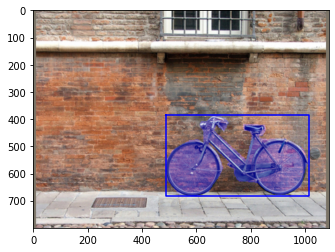

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


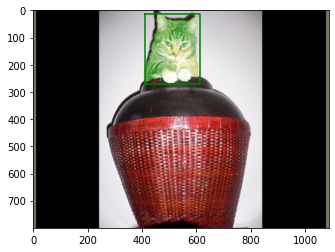

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


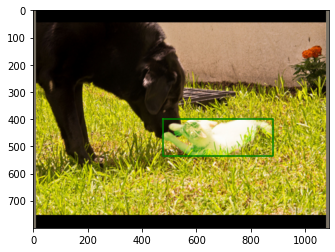

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


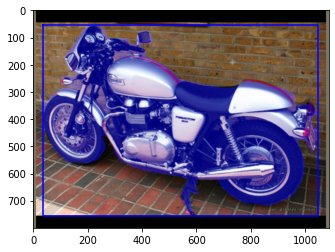

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


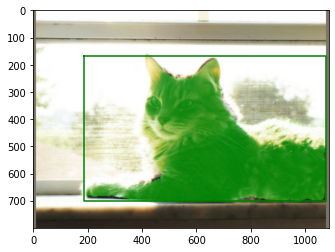

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


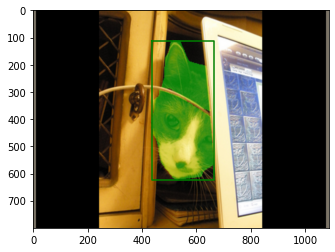

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


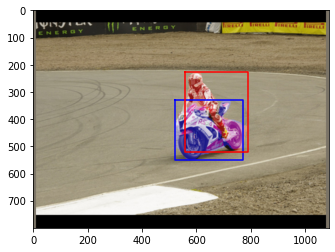

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


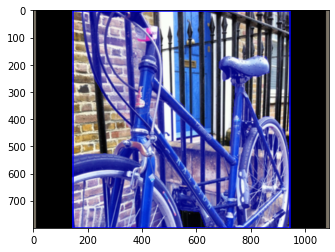

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


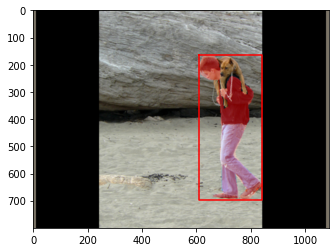

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


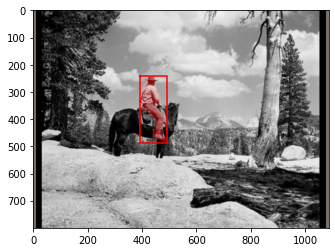

In [ ]:
#Lables:
#       1: Vehicle   : Blue
#       2: Human     : Red
#       3: Animals   : Green
save_path = '/content/drive/My Drive/CIS680_2019/HW4/'
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                              std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                              std = [ 1., 1., 1. ]),
                        ])

for iter, batch in enumerate(train_loader,0): 
  img          =   batch['images'][0,:,:,:]                                            #Tensor: (bz, 3, 800, 1088)
  label_list   =   batch['labels'][0].cpu().numpy().astype(np.int)                      #list  : len(bz)
  mask_list    =   batch['masks'][0].cpu().numpy()                                      #list  : len(bz){(n_obj,800,1088)}
  bbox_list    =   batch['bbox'][0].cpu().numpy()                                       #list  : len(bz){(n_obj,4)}
  index_list   =   batch['index'][0]                                                    #list  : len(bz)


  img = invTrans(img).cpu().numpy().transpose(1,2,0)
  combined_mask = np.zeros_like(img)
  for i in range(label_list.shape[0]):
    xA, xB, yA, yB = bbox_list[i,0], bbox_list[i,2], bbox_list[i,1], bbox_list[i,3]
    if label_list[i] == 1:
      combined_mask[:,:,2] += mask_list[i,:,:]
      plt.plot([xA,xB,xB,xA,xA],[yA,yA,yB,yB,yA], 'b-')
    if label_list[i] == 2:
      combined_mask[:,:,0] += mask_list[i,:,:]
      plt.plot([xA,xB,xB,xA,xA],[yA,yA,yB,yB,yA], 'r-')
    if label_list[i] == 3:
      combined_mask[:,:,1] += mask_list[i,:,:]
      plt.plot([xA,xB,xB,xA,xA],[yA,yA,yB,yB,yA], 'g-')
  mask_to_plot = combined_mask + img
  
  plt.imshow(img)
  plt.imshow(mask_to_plot,alpha=0.5)
  plt.savefig(save_path + str(iter))
  plt.show()

  if iter == 9:
    break

#5.2

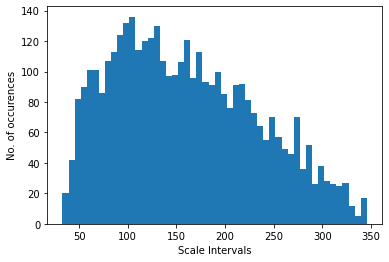

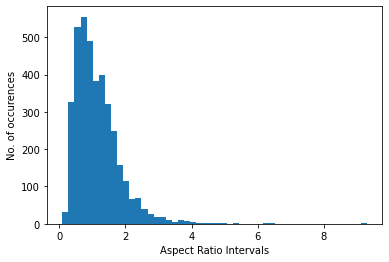

In [ ]:
save_path = '/content/drive/My Drive/Upenn Courses/2. Fall 2020/CIS 680: Advanced Topics in Machine Perception/Project 4: Mask RCNN/Part A/5.2/'
bbox   = np.load(paths[3], allow_pickle=True)          #Array of arrays: Shape: (len(dataset))  Each array: Shape: (num_labels for that image, 4)

scale_ = np.array([])
ar_ = np.array([])
for i in range(bbox.shape[0]):
  box = bbox[i]
  w = (box[:,2] - box[:,0]).reshape(1,-1)
  h = (box[:,3] - box[:,1]).reshape(1,-1)
  
  scale = np.sqrt(w*h)
  ar = w/h
  scale_ = np.append(scale_,scale)
  ar_    = np.append(ar_,   ar)

plt.hist(scale_,bins = 50)  # max occurence is between 95.364 - 101.62       #occurences: 136 
plt.xlabel('Scale Intervals')
plt.ylabel('No. of occurences')
# plt.savefig(save_path + 'scale_hist.png')
plt.show()
plt.hist(ar_,bins = 50)   # max occureance is between 0.4639 - 0.831677    #occurences: 555
plt.xlabel('Aspect Ratio Intervals')
plt.ylabel('No. of occurences') 
# plt.savefig(save_path + 'aspect ratio_hist.png')
plt.show()

# 5.3

In [ ]:
anchors = rpn_net.get_anchors()                 #anchors:   (grid[0],grid[1],4)
for epochs in range(epoch+1, num_epochs):
  for i, batch in enumerate(train_loader,0):
    img          =   batch['images']                           #Tensor: (bz, 3, 800, 1088)
    label_list   =   batch['labels']                           #list  : len(bz)
    mask_list    =   batch['masks']                            #list  : len(bz){(n_obj,800,1088)}
    bbox_list    =   batch['bbox']                             #list  : len(bz){(n_obj,4)}
    index_list   =   batch['index']                            #list  : len(bz) 
    
    #ground_clas_list:  len(bz){1,grid[0],grid[1]}
    #ground_coord_list: len(bz){4,grid[0],grid[1]}
    ground_clas_list, ground_coord_list = MultiApply(rpn_net.create_ground_truth, bbox_list, index_list, [rpn_net.anchors_param['grid_size']]*batch_size, [anchors]*batch_size, [img.shape[2:4]]*batch_size)  
    break
  break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


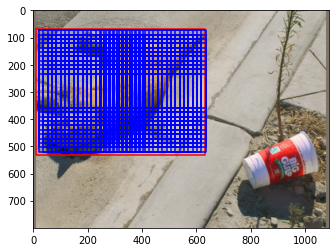

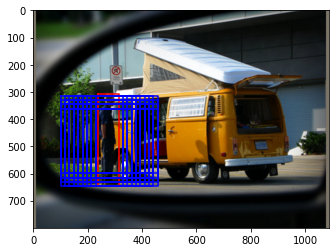

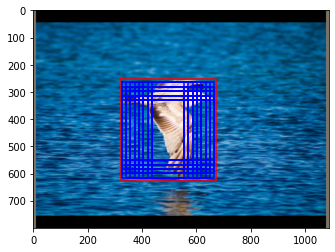

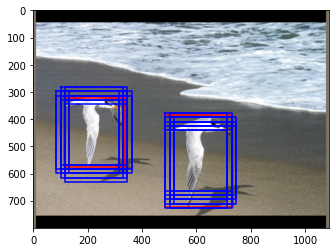

In [ ]:
save_path = '/content/drive/My Drive/CIS680_2019/HW4/'
bz = img.shape[0]
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                              std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                              std = [ 1., 1., 1. ]),
                        ])
anchors = rpn_net.get_anchors()
ground_clas_list, ground_coord_list = MultiApply(rpn_net.create_ground_truth, bbox_list, index_list, [rpn_net.anchors_param['grid_size']]*batch_size, [anchors]*batch_size, [img.shape[2:4]]*batch_size)  

for i in range(bz):
  cur_img = img[i]
  box     = bbox_list[i].cpu()
  gt_clas = ground_clas_list[i].cpu()

  gt_anchor = anchors[gt_clas[0]==1,:].T
  gt_plot = torch.zeros_like(gt_anchor)
  gt_plot[0,:] = gt_anchor[0,:] - gt_anchor[2,:]/2
  gt_plot[1,:] = gt_anchor[1,:] - gt_anchor[3,:]/2
  gt_plot[2,:] = gt_anchor[0,:] + gt_anchor[2,:]/2
  gt_plot[3,:] = gt_anchor[1,:] + gt_anchor[3,:]/2 

  cur_img = invTrans(cur_img).cpu().numpy().transpose(1,2,0)
  plt.figure()
  plt.imshow(cur_img)
  for obj in range(box.shape[0]):
    xA, xB, yA, yB = box[obj,0], box[obj,2], box[obj,1], box[obj,3]
    plt.plot([xA,xB,xB,xA,xA],[yA,yA,yB,yB,yA], 'r-')
  
  for obj in range(gt_plot.shape[1]):
    xA, xB, yA, yB = gt_plot[0,obj], gt_plot[2,obj], gt_plot[1,obj], gt_plot[3,obj]
    plt.plot([xA,xB,xB,xA,xA],[yA,yA,yB,yB,yA], 'b-')
    
  plt.savefig(save_path + str(i))
  plt.show()


#5.4

In [49]:
loss_list = []
loss_c_list = []
loss_r_list = []
'''
for i in range(40):
  print(i)
  # path = model_path + '/Copy of epoch' + str(i)
  path = model_path + 'epoch' + str(i)
  checkpoint = torch.load(path)
  loss_list.append((sum(checkpoint['loss'] )  / len(checkpoint['loss'])))
  loss_c_list.append((sum(checkpoint['loss_c'] )/ len(checkpoint['loss_c'])))
  loss_r_list.append((sum(checkpoint['loss_r'] )/ len(checkpoint['loss_r'])))
'''
i = 39
path = model_path + 'epoch' + str(i)
checkpoint = torch.load(path)
loss = checkpoint['loss']
loss_c=checkpoint['loss_c']
loss_r= checkpoint['loss_r']
loss_list = [sum(loss[i:i+653])/653 for i in range(0,26120,653)] 
loss_c_list = [sum(loss_c[i:i+653])/653 for i in range(0,26120,653)] 
loss_r_list = [sum(loss_r[i:i+653])/653 for i in range(0,26120,653)] 

loss   = checkpoint['loss']
loss_c = checkpoint['loss_c']
loss_r = checkpoint['loss_r']
loss_list = [sum(loss[i:i+653])/653 for i in range(0,26120,653)] 
loss_c_list = [sum(loss_c[i:i+653])/653 for i in range(0,26120,653)] 
loss_r_list = [sum(loss_r[i:i+653])/653 for i in range(0,26120,653)] 

losst = checkpoint['losst']
print(len(losst)/40)
losst_c  = checkpoint['losst_c']
losst_r = checkpoint['losst_r']
losst_list = [sum(losst[i:i+164])/164 for i in range(0,6560,164)] 
losst_c_list = [sum(losst_c[i:i+164])/164 for i in range(0,6560,164)] 
losst_r_list = [sum(losst_r[i:i+164])/164 for i in range(0,6560,164)] 

print(loss_list)

164.0
[274.1449309461515, 264.39272461404846, 261.8975478167921, 261.59215849428045, 257.74306618893496, 258.13510964877025, 259.86545880538216, 256.6466183041723, 257.6184417934914, 251.28138347351168, 252.23969670714865, 248.76645069209943, 248.68578664595645, 249.77473131912956, 245.14604819094788, 250.21728244565347, 242.11367723076486, 247.31381706950492, 243.30661452382483, 243.20885094822273, 245.38988554459436, 244.5235244260265, 244.7995752915854, 240.66274145806912, 238.45182307244806, 239.60112320810876, 237.98394963496676, 238.89170019549942, 237.63497758897486, 236.35361918848105, 238.537239845825, 234.98526540759147, 233.65980384908445, 233.36332424566902, 233.53446487263187, 234.94735880175557, 232.97568830925326, 234.58554108694173, 233.41838372830776, 232.69674575128016]


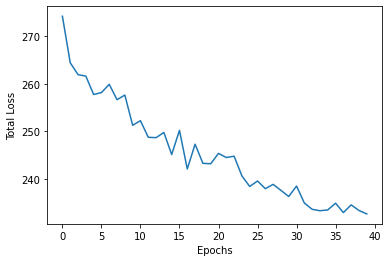

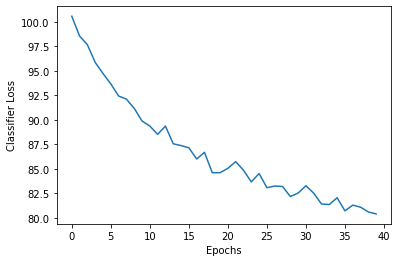

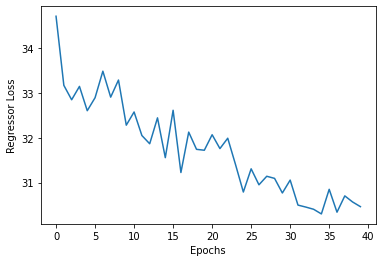

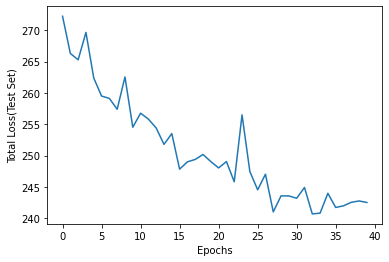

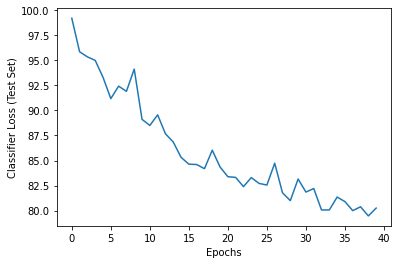

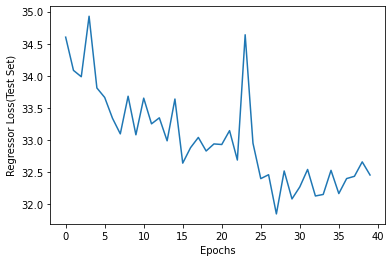

In [51]:
save_path = '/content/drive/My Drive/CIS680_2019/HW4/'
plt.figure(0)
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.savefig(save_path + 'total loss.png')
plt.figure(1)
plt.plot(loss_c_list)
plt.xlabel('Epochs')
plt.ylabel('Classifier Loss')
plt.savefig(save_path + 'loss_c.png')
plt.figure(2)
plt.plot(loss_r_list)
plt.xlabel('Epochs')
plt.ylabel('Regressor Loss')
plt.savefig(save_path + 'loss_r.png')


plt.figure(3)
plt.plot(losst_list)
plt.xlabel('Epochs')
plt.ylabel('Total Loss(Test Set)')
plt.savefig(save_path + 'total losst.png')
plt.figure(4)
plt.plot(losst_c_list)
plt.xlabel('Epochs')
plt.ylabel('Classifier Loss (Test Set)')
plt.savefig(save_path + 'losst_c.png')
plt.figure(5)
plt.plot(losst_r_list)
plt.xlabel('Epochs')
plt.ylabel('Regressor Loss(Test Set)')
plt.savefig(save_path + 'losst_r.png')

#5.5

In [ ]:
model_path = '/content/drive/My Drive/CIS680_2019/HW4/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epoch_to_load = 'epoch39'
path = model_path + str(epoch_to_load)
checkpoint = torch.load(path)
rpn_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
rpn_net.eval()

conf_thresh = 0.5
anchors = rpn_net.get_anchors()                 #anchors:   (grid[0],grid[1],4)
accuracy_ = []
img_count = 0
for i, batch in enumerate(test_loader,0):
  img          =   batch['images']                           #Tensor: (bz, 3, 800, 1088)
  label_list   =   batch['labels']                           #list  : len(bz)
  mask_list    =   batch['masks']                            #list  : len(bz){(n_obj,800,1088)}
  bbox_list    =   batch['bbox']                             #list  : len(bz){(n_obj,4)}
  index_list   =   batch['index']                            #list  : len(bz)

  #pred_clas: (bz,1,grid[0],grid[1])
  #pred_coord: (bz,4,grid[0],grid[1])
  pred_clas, pred_coord = rpn_net.forward(img) 
  #ground_clas_list:  len(bz){1,grid[0],grid[1]}
  #ground_coord_list: len(bz){4,grid[0],grid[1]}
  ground_clas_list, ground_coord_list = MultiApply(rpn_net.create_ground_truth, bbox_list, index_list, [rpn_net.anchors_param['grid_size']]*batch_size, [anchors]*batch_size, [img.shape[2:4]]*batch_size)  
  ground_clas  = torch.stack(ground_clas_list,dim=0)
  ground_coord = torch.stack(ground_coord_list,dim=0)

  positive_pred = (pred_clas > conf_thresh)
  ground_clas   = (ground_clas == 1)

  acc = (positive_pred == ground_clas).sum().item()
  acc = acc/(img.shape[0]*anchors.shape[0]*anchors.shape[1])
  accuracy_.append(acc)

accuracy = sum(accuracy_)/len(accuracy_)
print('Point wise accuracy = '+ str(accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Point wise accuracy = 0.7803071197991396


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


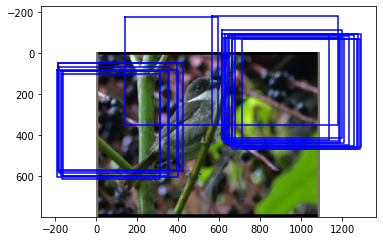

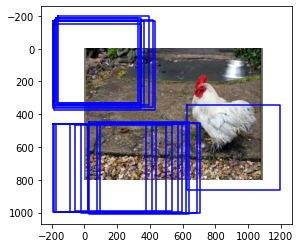

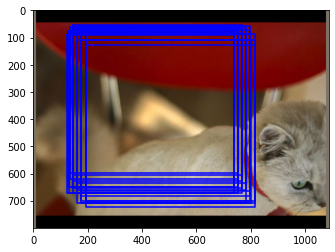

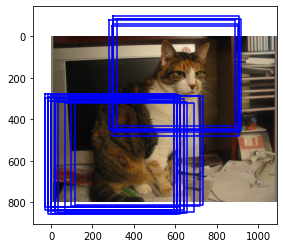

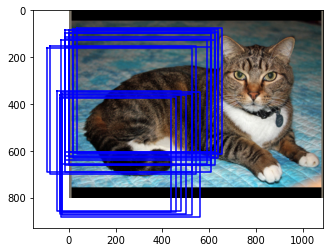

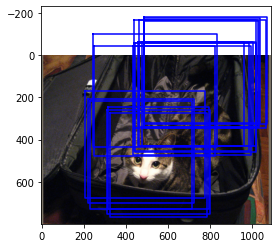

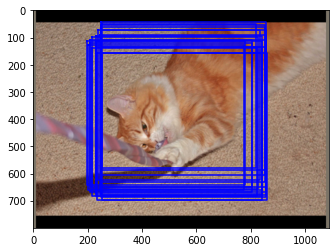

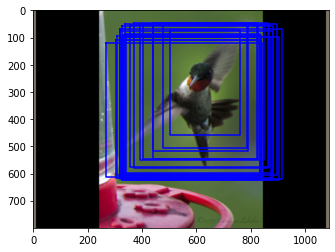

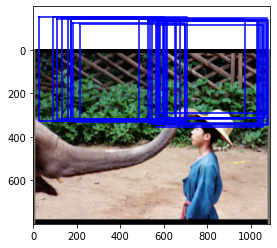

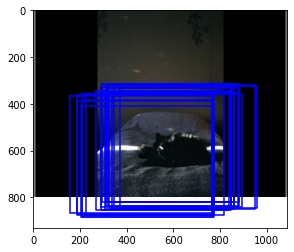

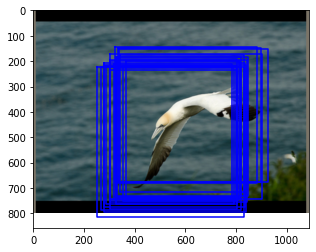

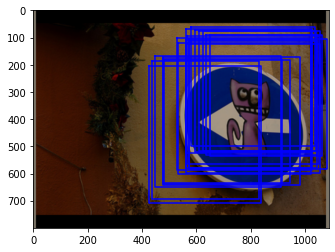

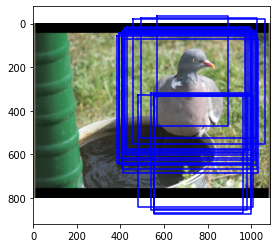

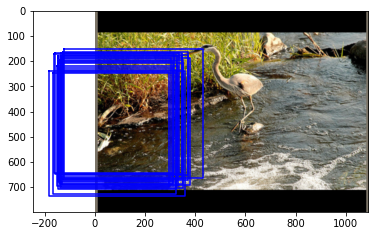

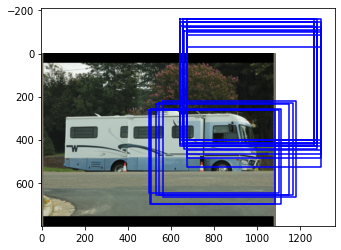

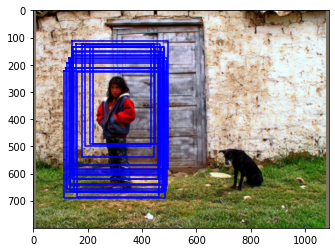

In [ ]:
save_path = '/content/drive/My Drive/CIS680_2019/HW4/'
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                              std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                              std = [ 1., 1., 1. ]),
                        ])
no = 0
rpn_net.eval()
anchors = rpn_net.get_anchors()                 #anchors:   (grid[0],grid[1],4)
for iter, batch in enumerate(test_loader,0): 
  img          =   batch['images']                                            #Tensor: (bz, 3, 800, 1088)


  #pred_clas: (bz,1,grid[0],grid[1])
  #pred_coord:(bz,4,grid[0],grid[1])
  pred_clas, pred_coord = rpn_net.forward(img) 

  # pred_clas, pred_coord = pred_clas.cpu(), pred_coord.cpu()
  for i in range(img.shape[0]):
    pred_scores = pred_clas[i,0,:,:].flatten()
    pred_boxes  = pred_coord[i,:,:,:].flatten(start_dim = 1)

    sort_scores, sort_idx = torch.sort(pred_scores,descending = True)
    top_scores = sort_scores[0:20]                                      #Shape: (20)
    top_boxes = pred_boxes[:,sort_idx[0:20]]                            #Shape: (4,20)

    anchors_plot = anchors.flatten(end_dim = -2)
    anchors_plot = anchors_plot[sort_idx[0:20],:]
    anchors_plot = anchors_plot.T                                       #Shape: (4,20)

    top_boxes[0,:] = top_boxes[0,:]*anchors_plot[2,:] + anchors_plot[0,:]
    top_boxes[1,:] = top_boxes[1,:]*anchors_plot[3,:] + anchors_plot[1,:]
    top_boxes[2,:] = torch.exp(top_boxes[2,:])*anchors_plot[2,:]
    top_boxes[3,:] = torch.exp(top_boxes[3,:])*anchors_plot[3,:]

    boxes_plot = torch.zeros_like(top_boxes)
    boxes_plot[0,:] = top_boxes[0,:] - top_boxes[2,:]/2
    boxes_plot[1,:] = top_boxes[1,:] - top_boxes[3,:]/2
    boxes_plot[2,:] = top_boxes[0,:] + top_boxes[2,:]/2
    boxes_plot[3,:] = top_boxes[1,:] + top_boxes[3,:]/2

    plt.figure()
    plt.imshow(invTrans(img[i,:,:,:]).cpu().numpy().transpose(1,2,0))
    for j in range(20):
      xA, xB, yA, yB = boxes_plot[0,j], boxes_plot[2,j], boxes_plot[1,j], boxes_plot[3,j]
      plt.plot([xA,xB,xB,xA,xA],[yA,yA,yB,yB,yA], 'b-')
    plt.savefig(save_path + str(no))
    no += 1
    plt.show()
  
  if iter == 3:
    break

#5.6

In [ ]:
rpn_net = RPNHead(device = device, anchors_param = anchors_param)
rpn_net.to(device)

model_path = '/content/drive/My Drive/CIS680_2019/HW4/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epoch_to_load = 'epoch39'
path = model_path + str(epoch_to_load)
checkpoint = torch.load(path)
rpn_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


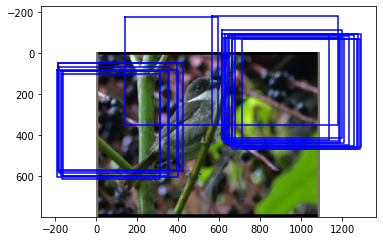

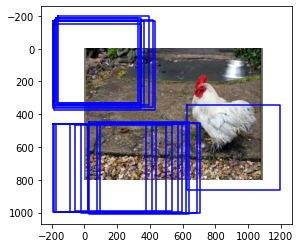

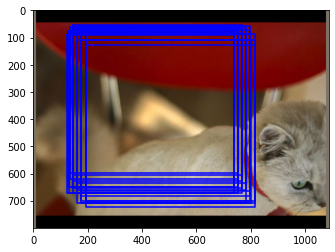

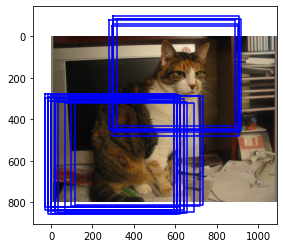

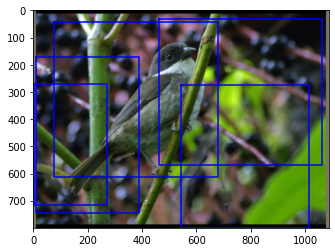

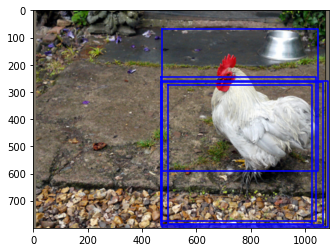

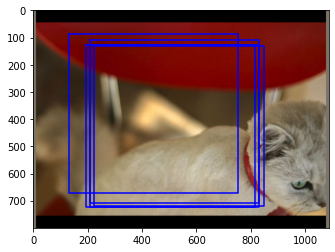

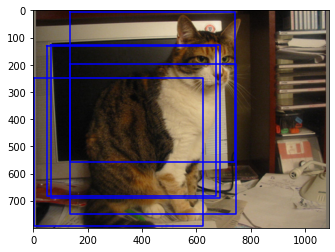

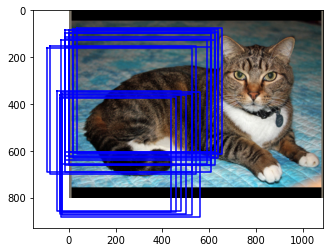

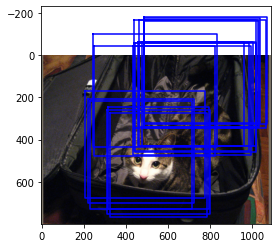

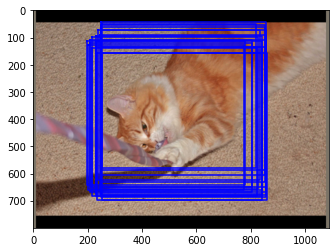

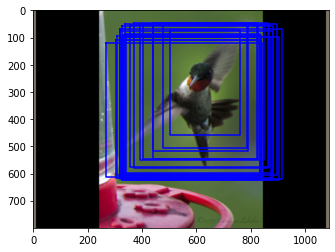

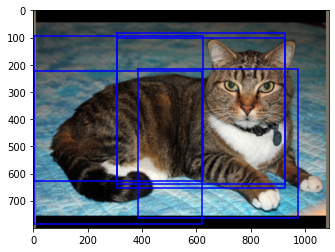

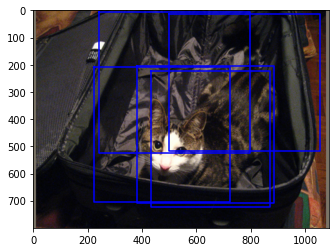

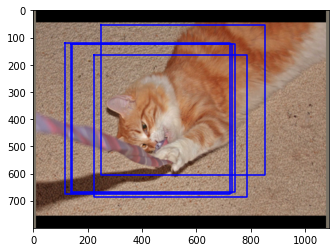

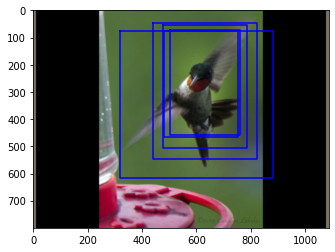

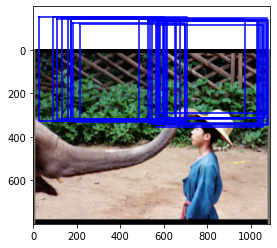

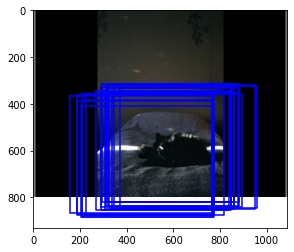

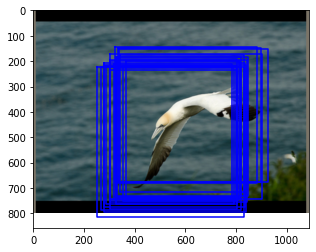

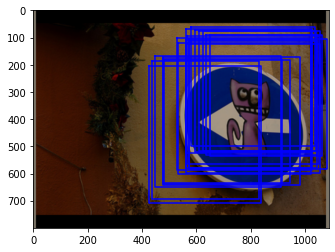

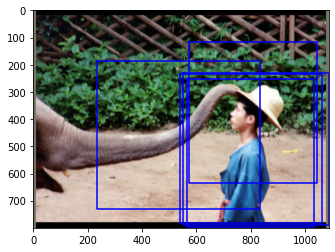

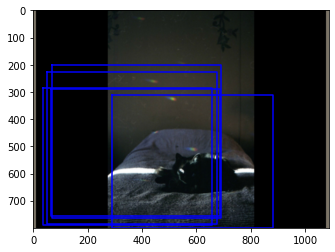

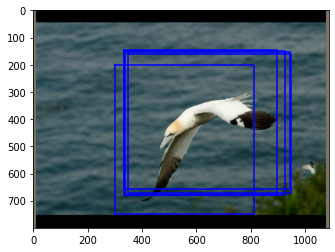

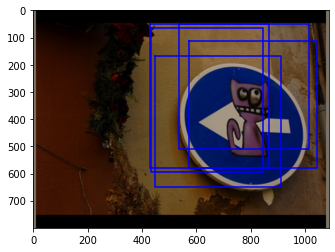

In [ ]:
save_path = '/content/drive/My Drive/CIS680_2019/HW4/'
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                              std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                              std = [ 1., 1., 1. ]),
                        ])
no = 0
rpn_net.eval()


anchors = rpn_net.get_anchors()                 #anchors:   (grid[0],grid[1],4)
for iter, batch in enumerate(test_loader,0): 
  img          =   batch['images']                                            #Tensor: (bz, 3, 800, 1088)


  #pred_clas: (bz,1,grid[0],grid[1])
  #pred_coord:(bz,4,grid[0],grid[1])

  pred_clas, pred_coord = rpn_net.forward(img)

  for i in range(img.shape[0]):
    pred_scores = pred_clas[i,0,:,:].flatten()
    pred_boxes  = pred_coord[i,:,:,:].flatten(start_dim = 1)

    sort_scores, sort_idx = torch.sort(pred_scores,descending = True)
    top_scores = sort_scores[0:50]                                      #Shape: (20)
    top_boxes = pred_boxes[:,sort_idx[0:50]]                            #Shape: (4,20)

    anchors_plot = anchors.flatten(end_dim = -2)
    anchors_plot = anchors_plot[sort_idx[0:50],:]
    anchors_plot = anchors_plot.T                                       #Shape: (4,20)

    top_boxes[0,:] = top_boxes[0,:]*anchors_plot[2,:] + anchors_plot[0,:]
    top_boxes[1,:] = top_boxes[1,:]*anchors_plot[3,:] + anchors_plot[1,:]
    top_boxes[2,:] = torch.exp(top_boxes[2,:])*anchors_plot[2,:]
    top_boxes[3,:] = torch.exp(top_boxes[3,:])*anchors_plot[3,:]

    boxes_plot = torch.zeros_like(top_boxes)
    boxes_plot[0,:] = top_boxes[0,:] - top_boxes[2,:]/2
    boxes_plot[1,:] = top_boxes[1,:] - top_boxes[3,:]/2
    boxes_plot[2,:] = top_boxes[0,:] + top_boxes[2,:]/2
    boxes_plot[3,:] = top_boxes[1,:] + top_boxes[3,:]/2

    plt.figure()
    plt.imshow(invTrans(img[i,:,:,:]).cpu().numpy().transpose(1,2,0))
    for j in range(20):
      xA, xB, yA, yB = boxes_plot[0,j], boxes_plot[2,j], boxes_plot[1,j], boxes_plot[3,j]
      plt.plot([xA,xB,xB,xA,xA],[yA,yA,yB,yB,yA], 'b-')
    no += 1
    plt.savefig(save_path + 'top50' + str(no))
    plt.show()

  #nms_clas_list: len(bz){5}
  #nms_prebox_list: len(bz){5,4}
  nms_clas_list, nms_prebox_list = rpn_net.postprocess(pred_clas,pred_coord, IOU_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=5)
  for i in range(len(nms_clas_list)):
    plt.figure()
    plt.imshow(invTrans(img[i,:,:,:]).cpu().numpy().transpose(1,2,0))
    boxes = nms_prebox_list[i]
    for j in range(boxes.shape[0]):
      xA, xB, yA, yB = boxes[j,0] - boxes[j,2]/2 , \
                       boxes[j,0] + boxes[j,2]/2 , \
                       boxes[j,1] - boxes[j,3]/2 , \
                       boxes[j,1] + boxes[j,3]/2
      plt.plot([xA,xB,xB,xA,xA],[yA,yA,yB,yB,yA], 'b-')
    plt.savefig(save_path + 'top20' + str(no))
    no += 1
    plt.show()
  
  if iter == 2:
    break